In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as mno
import faiss
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from fancyimpute import IterativeSVD
from sklearn import linear_model

In [2]:
#importing the database from the Kaggle competition
app_train = pd.read_csv("C:/data/application_train.csv")
print(app_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


In [3]:
#Easy summary of missing data
print(app_train.isna().sum())
missing_total = 100*(app_train.isnull().sum(axis = 1) > 0).sum()/len(app_train)
print("The percentage of rows with some missing values: ", missing_total,"%")

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64
The percentage of rows with some missing values:  97.202701691972 %


In [4]:
#More useful summary of missing data
null=pd.DataFrame(app_train.isnull().sum(),columns=["Null Values"])
null["% Missing Values"]=(app_train.isna().sum()/len(app_train)*100)
null = null[null["% Missing Values"] > 0]
null.style.background_gradient(cmap='viridis',low =0.2,high=0.1)

,Null Values,% Missing Values
AMT_ANNUITY,12,0.003902
AMT_GOODS_PRICE,278,0.090403
NAME_TYPE_SUITE,1292,0.420148
OWN_CAR_AGE,202929,65.990810
OCCUPATION_TYPE,96391,31.345545
CNT_FAM_MEMBERS,2,0.000650
EXT_SOURCE_1,173378,56.381073
EXT_SOURCE_2,660,0.214626
EXT_SOURCE_3,60965,19.825307
APARTMENTS_AVG,156061,50.749729


<Axes: >

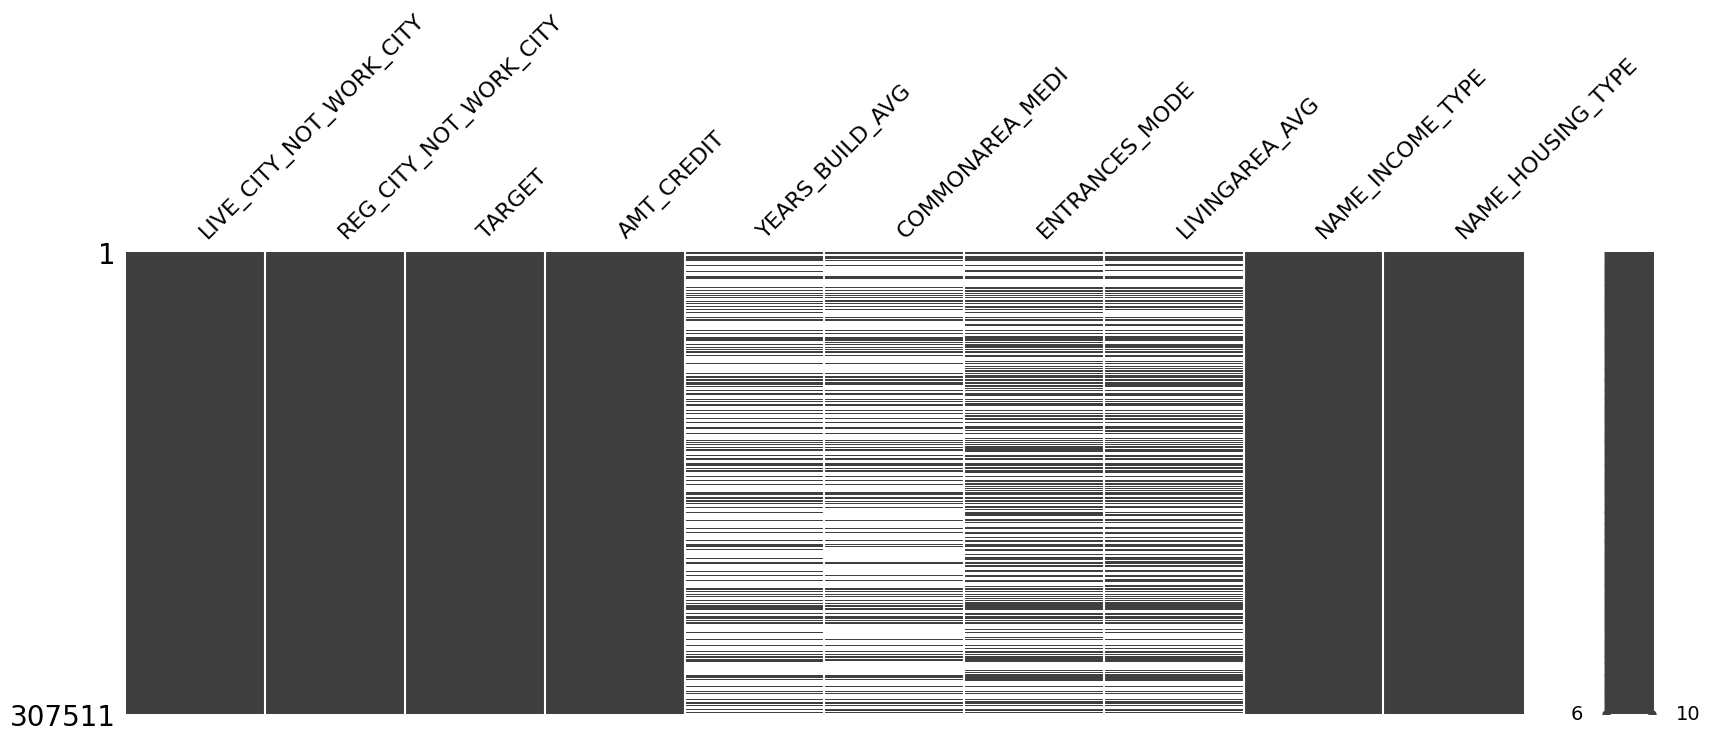

In [5]:
#Useful representation of missing data in dataset
random_columns = app_train.sample(n=10, axis=1)
mno.matrix(random_columns, figsize = (20, 6))

In [3]:
#Selecting only numeric data to impute
app_train_numeric = app_train.select_dtypes(include=['float'])

total_missing = app_train_numeric.isna().sum().sum()  # Total number of missing values
total_cells = app_train_numeric.size  # Total number of cells in the DataFrame
missing_percentage = (total_missing / total_cells) * 100

print(f"Total Percentage of Missing Data: {missing_percentage:.2f}%")

Total Percentage of Missing Data: 41.97%


In [4]:
zero_fraction = (app_train_numeric == 0).sum() / len(app_train_numeric)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):print(zero_fraction)

AMT_INCOME_TOTAL                0.000000
AMT_CREDIT                      0.000000
AMT_ANNUITY                     0.000000
AMT_GOODS_PRICE                 0.000000
REGION_POPULATION_RELATIVE      0.000000
DAYS_REGISTRATION               0.000260
OWN_CAR_AGE                     0.006940
CNT_FAM_MEMBERS                 0.000000
EXT_SOURCE_1                    0.000000
EXT_SOURCE_2                    0.000000
EXT_SOURCE_3                    0.000000
APARTMENTS_AVG                  0.002442
BASEMENTAREA_AVG                0.047950
YEARS_BEGINEXPLUATATION_AVG     0.001671
YEARS_BUILD_AVG                 0.000332
COMMONAREA_AVG                  0.027453
ELEVATORS_AVG                   0.278748
ENTRANCES_AVG                   0.001050
FLOORSMAX_AVG                   0.009554
FLOORSMIN_AVG                   0.007544
LANDAREA_AVG                    0.050730
LIVINGAPARTMENTS_AVG            0.001359
LIVINGAREA_AVG                  0.000924
NONLIVINGAPARTMENTS_AVG         0.177389
NONLIVINGAREA_AV

In [5]:
threshold = 0.2
data_filtered = app_train_numeric.loc[:, zero_fraction <= threshold]

total_missing = data_filtered.isna().sum().sum()  # Total number of missing values
total_cells = data_filtered.size  # Total number of cells in the DataFrame
missing_percentage = (total_missing / total_cells) * 100
print(f"Total Percentage of Missing Data: {missing_percentage:.2f}%")

Total Percentage of Missing Data: 47.65%


In [6]:
# Copy of the original dataset to compare against
original_data = data_filtered.copy()

# Parameters
missing_fraction = 0.05  # Fraction of data to make 'missing'
n_missing = int(missing_fraction * data_filtered.size)

# Flatten the data to a 1D array and identify indices of non-missing data points
non_missing_indices = np.flatnonzero(~np.isnan(data_filtered.values.ravel()))

# Randomly select data points from non-missing indices to "remove" (set as NaN), with a fixed seed
np.random.seed(42)
missing_indices = np.random.choice(non_missing_indices, n_missing, replace=False)
#data_filtered.values.ravel()[missing_indices] = np.nan
flat_data = data_filtered.values.ravel()
flat_data[missing_indices] = np.nan
data_filtered.iloc[:, :] = flat_data.reshape(data_filtered.shape)

total_missing = data_filtered.isna().sum().sum()  # Total number of missing values
total_cells = data_filtered.size  # Total number of cells in the DataFrame
missing_percentage = (total_missing / total_cells) * 100

print(f"Total Percentage of Missing Data: {missing_percentage:.2f}%")

Total Percentage of Missing Data: 52.65%


C:\Users\siems\AppData\Local\Temp\ipykernel_47664\4204958702.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered.iloc[:, :] = flat_data.reshape(data_filtered.shape)


In [10]:
#Mean Imputation
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(data_filtered), columns=data_filtered.columns)
missing_imputed = 100*(df_imputed.isnull().sum(axis = 1) > 0).sum()/len(df_imputed)
print("The percentage of rows with some missing values: ", missing_imputed,"%")

# Calculate effectiveness using MAPE
mask_missing = np.isnan(data_filtered.values.ravel())  # Identify missing points
original_values = original_data.values.ravel()[mask_missing]
imputed_values = df_imputed.values.ravel()[mask_missing]

# Filter out zero values in original_values to avoid division by zero
non_zero_non_nan_mask = (original_values != 0) & (~np.isnan(original_values))
original_values = original_values[non_zero_non_nan_mask]
imputed_values = imputed_values[non_zero_non_nan_mask]

# Mean Absolute Percentage Error calculation
if len(original_values) > 0:
    # Mean Absolute Percentage Error calculation
    mape = np.mean(np.abs((original_values - imputed_values) / original_values)) * 100
    print(f"Mean Absolute Percentage Error (MAPE) of Imputation: {mape:.2f}%")
else:
    print("No valid non-zero entries found for MAPE calculation.")

The percentage of rows with some missing values:  0.0 %
Mean Absolute Percentage Error (MAPE) of Imputation: 260.86%


In [11]:
#SVD Imputation
imputer = IterativeSVD(rank=4, max_iters=10, verbose=False)
imputed_data = imputer.fit_transform(data_filtered)
df_imputed_svd = pd.DataFrame(imputed_data, columns=data_filtered.columns)

missing_imputed = 100*(df_imputed_svd.isnull().sum(axis = 1) > 0).sum()/len(df_imputed_svd)
print("The percentage of rows with some missing values: ", missing_imputed,"%")

# Calculate effectiveness using MAPE
mask_missing = np.isnan(data_filtered.values.ravel())  # Identify missing points
original_values = original_data.values.ravel()[mask_missing]
imputed_values = df_imputed_svd.values.ravel()[mask_missing]

# Filter out zero values in original_values to avoid division by zero
non_zero_non_nan_mask = (original_values != 0) & (~np.isnan(original_values))
original_values = original_values[non_zero_non_nan_mask]
imputed_values = imputed_values[non_zero_non_nan_mask]

# Mean Absolute Percentage Error calculation
if len(original_values) > 0:
    # Mean Absolute Percentage Error calculation
    mape = np.mean(np.abs((original_values - imputed_values) / original_values)) * 100
    print(f"Mean Absolute Percentage Error (MAPE) of Imputation: {mape:.2f}%")
else:
    print("No valid non-zero entries found for MAPE calculation.")

The percentage of rows with some missing values:  0.0 %
Mean Absolute Percentage Error (MAPE) of Imputation: 198.72%


In [8]:
#SVD with ALS Imputation

# ALS-based matrix factorization for imputation
def als_impute(data, rank=4, max_iters=10, lambda_reg=0.1, tol=1e-4):
    """
    Impute missing values using ALS-based matrix factorization.
    Args:
        data: Input data as a NumPy array with NaNs for missing values.
        rank: Number of latent factors.
        max_iters: Maximum number of ALS iterations.
        lambda_reg: Regularization parameter.
        tol: Convergence tolerance.
    Returns:
        Imputed data as a NumPy array.
    """
    # Initialize U and V matrices with small random values
    num_users, num_items = data.shape
    U = np.random.rand(num_users, rank)
    V = np.random.rand(num_items, rank)

    # Mask for missing values
    mask = ~np.isnan(data)
    data = np.nan_to_num(data)  # Replace NaNs with zeros for computation

    for iteration in range(max_iters):
        # Solve for U with fixed V
        for i in range(num_users):
            V_masked = V[mask[i, :], :]
            ratings_masked = data[i, mask[i, :]]
            if len(ratings_masked) > 0:
                U[i, :] = np.linalg.solve(
                    V_masked.T @ V_masked + lambda_reg * np.eye(rank),
                    V_masked.T @ ratings_masked
                )

        # Solve for V with fixed U
        for j in range(num_items):
            U_masked = U[mask[:, j], :]
            ratings_masked = data[mask[:, j], j]
            if len(ratings_masked) > 0:
                V[j, :] = np.linalg.solve(
                    U_masked.T @ U_masked + lambda_reg * np.eye(rank),
                    U_masked.T @ ratings_masked
                )

        # Compute reconstruction error (optional for monitoring)
        reconstructed = U @ V.T
        error = np.sqrt(np.sum((mask * (data - reconstructed)) ** 2) / mask.sum())
        if error < tol:
            print(f"Converged at iteration {iteration}")
            break

    return U @ V.T  # Reconstructed matrix with imputed values

# Apply ALS imputation
data_array = data_filtered.values
imputed_data_als = als_impute(data_array, rank=4, max_iters=15, lambda_reg=0.01, tol=1e-4)
df_imputed_als = pd.DataFrame(imputed_data_als, columns=data_filtered.columns)

# Check for rows with missing values after imputation
missing_imputed = 100 * (df_imputed_als.isnull().sum(axis=1) > 0).sum() / len(df_imputed_als)
print("The percentage of rows with some missing values: ", missing_imputed, "%")

# Calculate effectiveness using MAPE
mask_missing = np.isnan(data_array.ravel())  # Identify missing points
original_values = original_data.values.ravel()[mask_missing]
imputed_values = df_imputed_als.values.ravel()[mask_missing]

# Filter out zero values in original_values to avoid division by zero
non_zero_non_nan_mask = (original_values != 0) & (~np.isnan(original_values))
original_values = original_values[non_zero_non_nan_mask]
imputed_values = imputed_values[non_zero_non_nan_mask]

# Mean Absolute Percentage Error calculation
if len(original_values) > 0:
    mape = np.mean(np.abs((original_values - imputed_values) / original_values)) * 100
    print(f"Mean Absolute Percentage Error (MAPE) of Imputation: {mape:.2f}%")
else:
    print("No valid non-zero entries found for MAPE calculation.")


The percentage of rows with some missing values:  0.0 %
Mean Absolute Percentage Error (MAPE) of Imputation: 222.53%


In [16]:
#Regression Imputation
imputer = IterativeImputer(random_state=42, max_iter=15, initial_strategy='median')
imputed_data = imputer.fit_transform(data_filtered)
df_imputed_reg = pd.DataFrame(imputed_data, columns=data_filtered.columns)

missing_imputed = 100*(df_imputed_reg.isnull().sum(axis = 1) > 0).sum()/len(df_imputed_reg)
print("The percentage of rows with some missing values: ", missing_imputed,"%")

# Calculate effectiveness using MAPE
mask_missing = np.isnan(data_filtered.values.ravel())  # Identify missing points
original_values = original_data.values.ravel()[mask_missing]
imputed_values = df_imputed_reg.values.ravel()[mask_missing]

# Filter out zero values in original_values to avoid division by zero
non_zero_non_nan_mask = (original_values != 0) & (~np.isnan(original_values))
original_values = original_values[non_zero_non_nan_mask]
imputed_values = imputed_values[non_zero_non_nan_mask]

# Mean Absolute Percentage Error calculation
if len(original_values) > 0:
    # Mean Absolute Percentage Error calculation
    mape = np.mean(np.abs((original_values - imputed_values) / original_values)) * 100
    print(f"Mean Absolute Percentage Error (MAPE) of Imputation: {mape:.2f}%")
else:
    print("No valid non-zero entries found for MAPE calculation.")

The percentage of rows with some missing values:  0.0 %
Mean Absolute Percentage Error (MAPE) of Imputation: 153.69%


In [18]:
# Dictionary to store MAPE for each column
mape_by_column = {}

# Loop through each column in the original data
for column in original_data.columns:
    # Identify missing points in the current column
    mask_missing = np.isnan(data_filtered[column].values)  # Identify missing points
    original_values = original_data[column].values[mask_missing]
    imputed_values = df_imputed_reg[column].values[mask_missing]
    
    # Filter out zero values in original_values to avoid division by zero
    non_zero_non_nan_mask = (original_values != 0) & (~np.isnan(original_values))
    original_values = original_values[non_zero_non_nan_mask]
    imputed_values = imputed_values[non_zero_non_nan_mask]
    
    # Mean Absolute Percentage Error calculation
    if len(original_values) > 0:
        mape = np.mean(np.abs((original_values - imputed_values) / original_values)) * 100
        mape_by_column[column] = mape
    else:
        mape_by_column[column] = None  # Indicate no valid entries for MAPE calculation

# Print MAPE for each column
for column, mape in mape_by_column.items():
    if mape is not None:
        print(f"MAPE for column '{column}': {mape:.2f}%")
    else:
        print(f"No valid non-zero entries found for MAPE calculation in column '{column}'.")


MAPE for column 'AMT_INCOME_TOTAL': 60.87%
MAPE for column 'AMT_CREDIT': 15.21%
MAPE for column 'AMT_ANNUITY': 28.25%
MAPE for column 'AMT_GOODS_PRICE': 14.67%
MAPE for column 'REGION_POPULATION_RELATIVE': 89.67%
MAPE for column 'DAYS_REGISTRATION': 748.74%
MAPE for column 'OWN_CAR_AGE': 155.64%
MAPE for column 'CNT_FAM_MEMBERS': 41.40%
MAPE for column 'EXT_SOURCE_1': 57.93%
MAPE for column 'EXT_SOURCE_2': 324.50%
MAPE for column 'EXT_SOURCE_3': 408.86%
MAPE for column 'APARTMENTS_AVG': 8.66%
MAPE for column 'BASEMENTAREA_AVG': 8.14%
MAPE for column 'YEARS_BEGINEXPLUATATION_AVG': 0.17%
MAPE for column 'YEARS_BUILD_AVG': 0.64%
MAPE for column 'COMMONAREA_AVG': 16.22%
MAPE for column 'ENTRANCES_AVG': 3.32%
MAPE for column 'FLOORSMAX_AVG': 2.95%
MAPE for column 'FLOORSMIN_AVG': 4.33%
MAPE for column 'LANDAREA_AVG': 7.12%
MAPE for column 'LIVINGAPARTMENTS_AVG': 8.49%
MAPE for column 'LIVINGAREA_AVG': 7.47%
MAPE for column 'NONLIVINGAPARTMENTS_AVG': 45.97%
MAPE for column 'NONLIVINGAREA_AVG

In [15]:
# Convert to NumPy array for FAISS processing
data_filled = data_filtered.to_numpy().astype('float32')

# FAISS index creation and fitting
d = data_filled.shape[1]  # dimensionality of data
index = faiss.IndexFlatL2(d)  # L2 distance for nearest neighbor search
index.add(data_filled)  # Add data to the FAISS index

def impute_with_ann(df, index, k=5):
    df_imputed = df.copy()
    # Use tqdm to add a progress bar
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Imputing Missing Values"):
        if row.isnull().any():  # Only process rows with missing values
            # Find k nearest neighbors for the current row (excluding itself)
            row_filled = row.fillna(df.mean()).to_numpy().astype('float32').reshape(1, -1)
            distances, indices = index.search(row_filled, k + 1)  # k + 1 to exclude self-neighbor
            
            # Filter out itself (distance 0) if present
            neighbors_idx = [i for i, dist in zip(indices[0], distances[0]) if dist > 0][:k]
            
            # Use mean of neighbors to impute missing values
            neighbors = df.iloc[neighbors_idx]
            imputed_val = neighbors.mean(axis=0)
            
            # Fill in missing values
            for col in df.columns:
                if pd.isna(row[col]):
                    df_imputed.at[idx, col] = imputed_val[col]
    return df_imputed

# Perform imputation
df_imputed_ann = impute_with_ann(data_filtered, index, k=5)

missing_imputed = 100*(df_imputed_ann.isnull().sum(axis = 1) > 0).sum()/len(df_imputed_ann)
print("The percentage of rows with some missing values: ", missing_imputed,"%")

# Calculate effectiveness using MAPE
mask_missing = np.isnan(data_filtered.values.ravel())  # Identify missing points
original_values = original_data.values.ravel()[mask_missing]
imputed_values = df_imputed_ann.values.ravel()[mask_missing]

# Filter out zero values in original_values to avoid division by zero
non_zero_non_nan_mask = (original_values != 0) & (~np.isnan(original_values))
original_values = original_values[non_zero_non_nan_mask]
imputed_values = imputed_values[non_zero_non_nan_mask]

# Mean Absolute Percentage Error calculation
if len(original_values) > 0:
    # Mean Absolute Percentage Error calculation
    mape = np.mean(np.abs((original_values - imputed_values) / original_values)) * 100
    print(f"Mean Absolute Percentage Error (MAPE) of Imputation: {mape:.2f}%")
else:
    print("No valid non-zero entries found for MAPE calculation.")

Imputing Missing Values: 100%|█████████████████████████████████████████████████████████████████████| 307511/307511 [11:48:09<00:00,  7.24it/s]


The percentage of rows with some missing values:  0.0 %
Mean Absolute Percentage Error (MAPE) of Imputation: 264.47%


In [ ]:
# Scale the data to improve KNN performance
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_filtered)

# Initialize the KNNImputer
# n_neighbors=5 is a good starting point, but you can adjust it based on your dataset
knn_imputer = KNNImputer(n_neighbors=5, weights="distance", metric="nan_euclidean")

# Perform the imputation
# fit_transform method is faster as it fits and transforms in one go
data_imputed_out = knn_imputer.fit_transform(data_scaled)

# Convert back to DataFrame and revert scaling
df_imputed_knn = pd.DataFrame(scaler.inverse_transform(data_imputed_out), columns=data_filtered.columns)

missing_imputed = 100*(df_imputed_knn.isnull().sum(axis = 1) > 0).sum()/len(df_imputed_knn)
print("The percentage of rows with some missing values: ", missing_imputed,"%")

# Calculate effectiveness using MAPE
mask_missing = np.isnan(data_filtered.values.ravel())  # Identify missing points
original_values = original_data.values.ravel()[mask_missing]
imputed_values = df_imputed_knn.values.ravel()[mask_missing]

# Filter out zero values in original_values to avoid division by zero
non_zero_non_nan_mask = (original_values != 0) & (~np.isnan(original_values))
original_values = original_values[non_zero_non_nan_mask]
imputed_values = imputed_values[non_zero_non_nan_mask]

# Mean Absolute Percentage Error calculation
if len(original_values) > 0:
    # Mean Absolute Percentage Error calculation
    mape = np.mean(np.abs((original_values - imputed_values) / original_values)) * 100
    print(f"Mean Absolute Percentage Error (MAPE) of Imputation: {mape:.2f}%")
else:
    print("No valid non-zero entries found for MAPE calculation.")